# Environment

In [1]:
import pandas as pd
import numpy as np
from intervaltree import IntervalTree
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import os

# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

import importlib
import functions
importlib.reload(functions)
from functions import *

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [2]:
# Example usage
peaks_file = "./DATA/Peak.csv"
dexseq_file = "./output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv"
output_prefix = "./output_v38/overlap_analysis"

# Load and process data

In [3]:
# Load and process data
peaks_df, dexseq_df = load_and_process_data(peaks_file, dexseq_file)

In [4]:
pd.set_option('display.max_columns', None)
peaks_df.head()

,Row.names,seqnames,start,end,width,annotation,geneChr,geneStart,geneEnd,geneLength,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,ASE1,ASE2,GeneID,Ctrl.bam,V5.bam,difference,FC,L2FC
0,chr15:25051475-25051745,chr15,25051475.0,25051745.0,271.0,Promoter (<=1kb),15.0,25051477.0,25051571.0,95.0,100033413.0,ENST00000384335.1,0.0,ENSG00000207063,SNORD116-1,"small nucleolar RNA, C/D box 116-1",NaN,NaN,controlledV5_peak_329,0,961,961,961.0,9.908392621
1,chr2:74154059-74154316,chr2,74154059.0,74154316.0,258.0,3' UTR,2.0,74148079.0,74151952.0,3874.0,100507171.0,ENST00000656407.1,5980.0,ENSG00000225439,BOLA3-DT,BOLA3 divergent transcript,NaN,NaN,controlledV5_peak_575,0,31,31,31.0,4.95419631
2,chr17:21198291-21198758,chr17,21198291.0,21198758.0,468.0,3' UTR,17.0,21184385.0,21193265.0,8881.0,25979.0,ENST00000581463.1,13906.0,ENSG00000109016,DHRS7B,dehydrogenase/reductase 7B,NaN,NaN,controlledV5_peak_423,0,20,20,20.0,4.321928095
3,chr17:744815-745029,chr17,744815.0,745029.0,215.0,3' UTR,17.0,747844.0,752038.0,4195.0,50628.0,ENST00000574958.1,7009.0,ENSG00000179409,GEMIN4,gem nuclear organelle associated protein 4,NaN,NaN,controlledV5_peak_403,0,18,18,18.0,4.169925001
4,chr10:27134830-27135032,chr10,27134830.0,27135032.0,203.0,Promoter (1-2kb),10.0,27123547.0,27136337.0,12791.0,10730.0,ENST00000463270.1,1305.0,ENSG00000136758,YME1L1,YME1 like 1 ATPase,NaN,NaN,controlledV5_peak_142,0,17,17,17.0,4.087462841


In [5]:
peaks_df = peaks_df.rename(columns={"Row.names": "peak_name"})

In [6]:
print(list(peaks_df['seqnames'][:5]))
print(list(peaks_df.iloc[:5].index))

['chr15', 'chr2', 'chr17', 'chr17', 'chr10']
[0, 1, 2, 3, 4]


In [7]:
dexseq_df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3,overlapping_genes,current_genome_genes,gene_assignment_confident
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14,NaN,NaN,True
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375,NaN,NaN,True
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802,NaN,NaN,True
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4,NaN,NaN,True
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613,NaN,NaN,True


In [8]:
dexseq_df = dexseq_df.rename(columns={"Unnamed: 0": "dexseq_name"})

In [9]:
dexseq_df.columns

Index(['dexseq_name', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3',
       'overlapping_genes', 'current_genome_genes',
       'gene_assignment_confident'],
      dtype='object')

In [10]:
print(list(dexseq_df['genomicData.seqnames'][:5]))
print(list(dexseq_df['featureID'][:5]))


['chrX', 'chrX', 'chrX', 'chrX', 'chrX']
['E001', 'E002', 'E003', 'E004', 'E005']


In [11]:
# Create interval tree for efficient overlap detection
peaks_tree = create_interval_tree(peaks_df)

In [12]:
list(peaks_tree.items())[:10]



[Interval(44065741.0, 44065975.0, {'seqnames': 'chr2', 'peak_id': 691, 'peak_name': 'chr2:44065741-44065975'}),
 Interval(2431546.0, 2431734.0, {'seqnames': 'chr19', 'peak_id': 619, 'peak_name': 'chr19:2431546-2431734'}),
 Interval(75321808.0, 75322308.0, {'seqnames': 'chr15', 'peak_id': 1085, 'peak_name': 'chr15:75321808-75322308'}),
 Interval(253490.0, 253707.0, {'seqnames': 'chr10', 'peak_id': 37, 'peak_name': 'chr10:253490-253707'}),
 Interval(47783878.0, 47784227.0, {'seqnames': 'chr12', 'peak_id': 389, 'peak_name': 'chr12:47783878-47784227'}),
 Interval(41604043.0, 41604252.0, {'seqnames': 'chr22', 'peak_id': 785, 'peak_name': 'chr22:41604043-41604252'}),
 Interval(1787781.0, 1788035.0, {'seqnames': 'chr16', 'peak_id': 718, 'peak_name': 'chr16:1787781-1788035'}),
 Interval(19378387.0, 19378889.0, {'seqnames': 'chr9', 'peak_id': 1063, 'peak_name': 'chr9:19378387-19378889'}),
 Interval(37925659.0, 37925853.0, {'seqnames': 'chr22', 'peak_id': 449, 'peak_name': 'chr22:37925659-379258

In [13]:
# Find overlaps
overlaps = find_overlaps(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [14]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,overlap_start,overlap_end,overlap_length,exon_log2fc,exon_padj
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,47132257.0,47132374.0,117.0,-0.104318,0.000000e+00
1,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,57428714.0,57428937.0,223.0,-0.222241,0.000000e+00
2,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,57428938.0,57428958.0,20.0,-0.263524,0.000000e+00
3,E014,160,chr7:107160282-107160602,ENSG00000005249.13:E014,chr7,107160282.0,107160602.0,320.0,-0.137301,1.030564e-21
4,E067,395,chr16:3850321-3850506,ENSG00000005339.15:E067,chr16,3850322.0,3850506.0,184.0,0.065804,3.074697e-276


In [15]:
overlaps_df.shape

(1784, 10)

In [16]:
# Save overlaps to file
overlaps_df.to_csv(f"{output_prefix}_overlaps.csv", index=False)

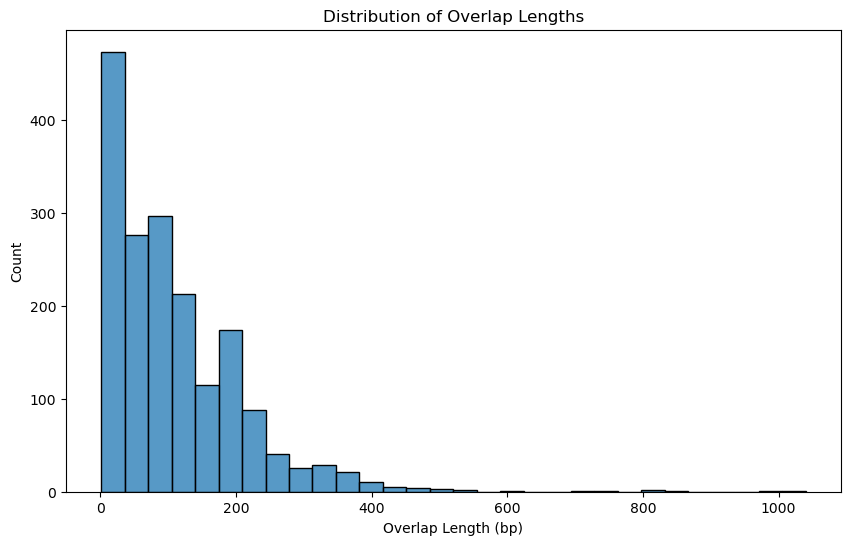

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_overlap_lengths(overlaps_df, ax)


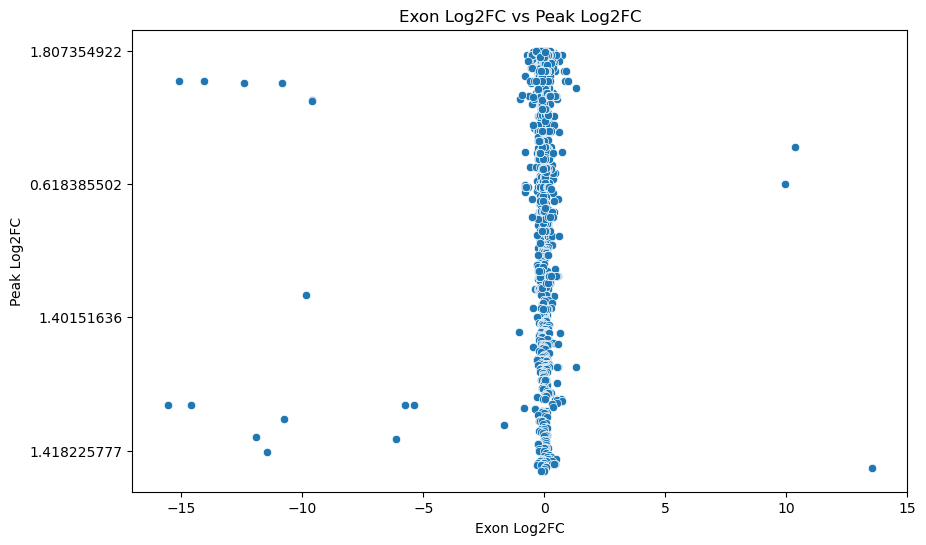

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_fc_correlation(overlaps_df, peaks_df, ax)

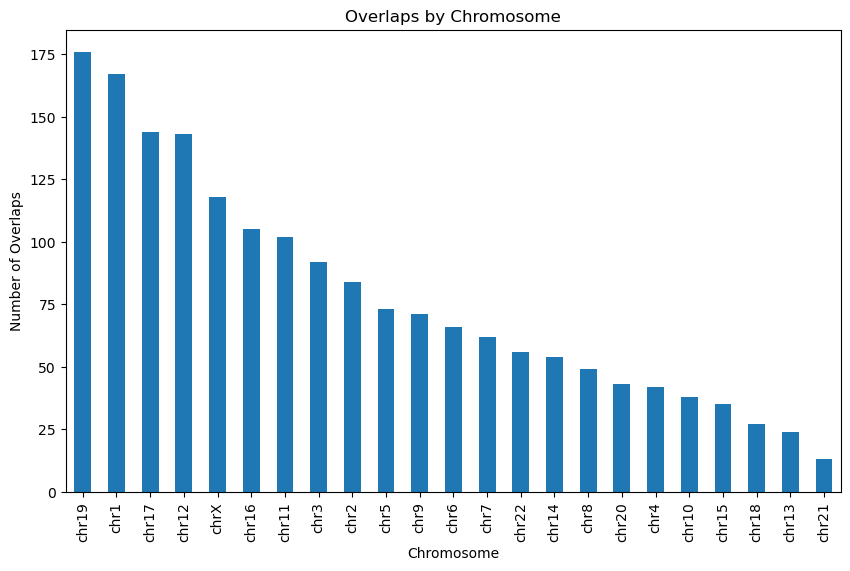

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_chromosome_distribution(overlaps_df, ax)

In [20]:
total_peaks = len(peaks_df)
total_exons = len(dexseq_df)
peaks_with_overlaps = len(overlaps_df['peak_id'].unique())
exons_with_overlaps = len(overlaps_df['exon_id'].unique())

print(f"Total Peaks: {total_peaks}")
print(f"Total Diff. Expressed Exons: {total_exons}")
print(f"Peaks with Overlaps: {peaks_with_overlaps}")
print(f"Exons with Overlaps: {exons_with_overlaps}")
print(f"Total Overlap Events: {len(overlaps_df)}")

Total Peaks: 1136
Total Diff. Expressed Exons: 518582
Peaks with Overlaps: 808
Exons with Overlaps: 138
Total Overlap Events: 1784


In [21]:
# # Find overlaps and distances
overlaps = find_overlaps2(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [22]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj
0,E001,641,chr2:37222376-37222562,ENSG00000003509.16:E001,chr2,-9175.0,0.0,0.444977,0.0
1,E002,641,chr2:37222376-37222562,ENSG00000003509.16:E002,chr2,-9191.0,0.0,-0.146748,0.0
2,E003,641,chr2:37222376-37222562,ENSG00000003509.16:E003,chr2,-9201.5,0.0,-0.019952,0.0
3,E004,641,chr2:37222376-37222562,ENSG00000003509.16:E004,chr2,-9214.5,0.0,0.129825,0.0
4,E005,641,chr2:37222376-37222562,ENSG00000003509.16:E005,chr2,-9255.5,0.0,0.115130,0.0


In [23]:
dexseq_df.head()

,dexseq_name,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3,overlapping_genes,current_genome_genes,gene_assignment_confident
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14,NaN,NaN,True
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375,NaN,NaN,True
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802,NaN,NaN,True
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4,NaN,NaN,True
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613,NaN,NaN,True


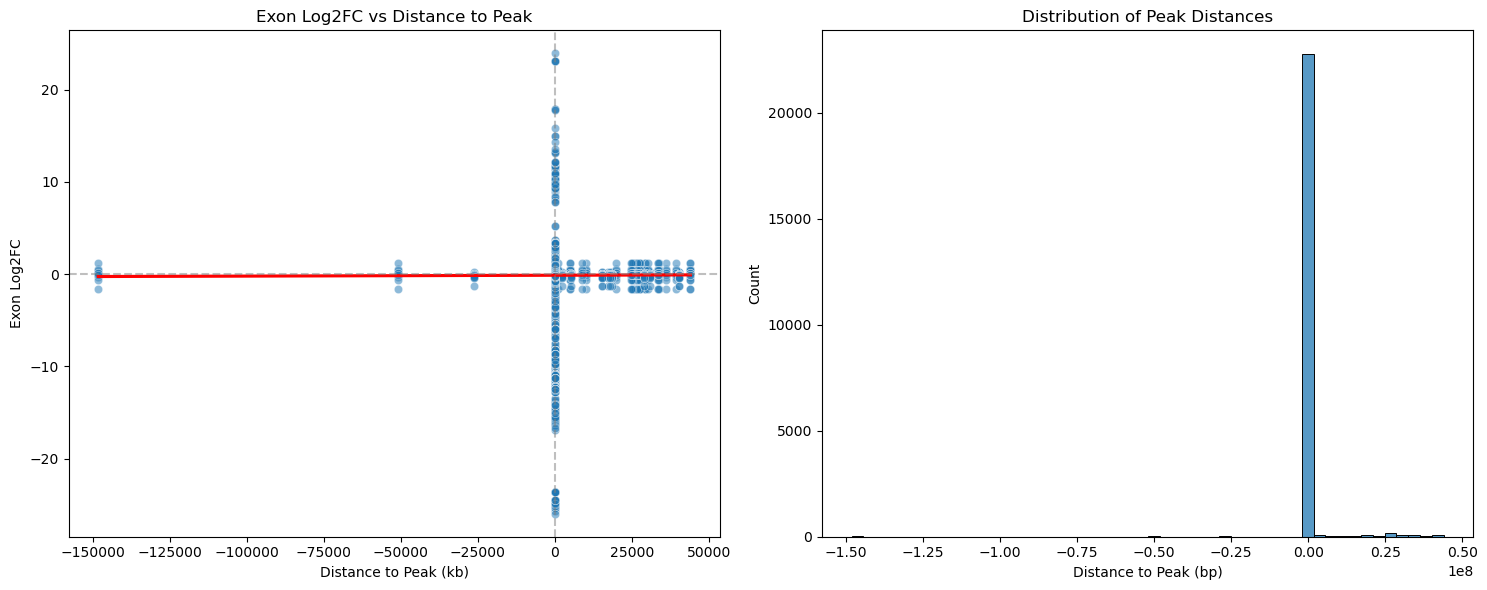

In [24]:
# Create visualization
fig = visualize_distance_analysis(overlaps_df)
plt.show()

# Complementarity analysis

In [25]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

cASE1 = 'CTTTTCCAAGGAATGTT'
cASE2 = 'TTCCGATGAGAATGACG'

In [75]:
enriched_overlaps_df3 = analyze_overlaps_with_als_optimized(overlaps_df, dexseq_df)

Starting ALS complementarity analysis...
Using 70 CPU cores for parallel processing
Split data into 283 chunks of approximately 83 rows each
Starting parallel processing...
Completed chunk 21/283
Completed chunk 5/283
Completed chunk 2/283
Completed chunk 39/283
Completed chunk 12/283


In [76]:
# enriched_overlaps_df3 = analyze_overlaps_with_als(overlaps_df, dexseq_df)

# Load the data back

In [77]:
output_path = "output_v38/enriched_overlaps_with_als.csv"
pickle_path = "output_v38/enriched_overlaps_with_als.pkl"

In [78]:
# %%script false --no-raise-error
# Save as pickle (better for preserving data types and complex objects)
enriched_overlaps_df3.to_pickle(pickle_path)

# Save as CSV
enriched_overlaps_df3.to_csv(output_path, index=False)

In [79]:
# Load the data back

# From CSV
# loaded_df_csv = pd.read_csv(output_path)

# From pickle
enriched_overlaps_df3 = pd.read_pickle(pickle_path)

In [80]:
enriched_overlaps_df3.shape

(23462, 22)

In [81]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length
0,E038,1052,chr1:114749820-114750043,ENSG00000009307.16:E038,chr1,3230.5,0.0,-0.123543,0.000000e+00,3.2305,E038,8.0,6.0,317.0,E037,5.0,7.0,147.0,E039,5.0,5.0,102.0
1,E039,1052,chr1:114749820-114750043,ENSG00000009307.16:E039,chr1,1564.0,0.0,-0.080076,0.000000e+00,1.5640,E039,5.0,5.0,102.0,E038,8.0,6.0,317.0,E040,8.0,6.0,153.0
2,E040,1052,chr1:114749820-114750043,ENSG00000009307.16:E040,chr1,34.5,152.0,-0.072601,6.205184e-182,0.0345,E040,8.0,6.0,153.0,E039,5.0,5.0,102.0,E041,6.0,5.0,217.0
3,E041,1052,chr1:114749820-114750043,ENSG00000009307.16:E041,chr1,-150.5,69.0,-0.056152,2.287113e-190,-0.1505,E041,6.0,5.0,217.0,E040,8.0,6.0,153.0,E042,4.0,3.0,17.0
4,E042,1052,chr1:114749820-114750043,ENSG00000009307.16:E042,chr1,-267.5,0.0,0.105016,0.000000e+00,-0.2675,E042,4.0,3.0,17.0,E041,6.0,5.0,217.0,E043,7.0,5.0,112.0


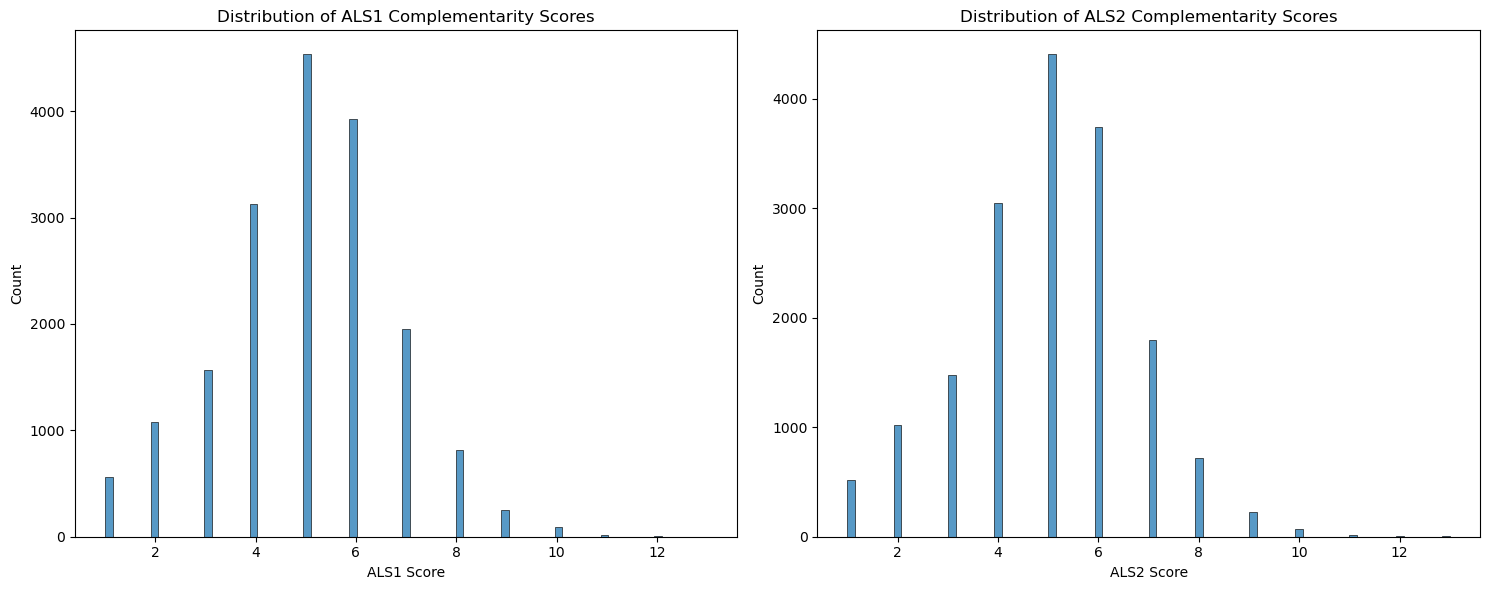

In [82]:
# Visualize ALS scores distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=enriched_overlaps_df3, x='current_exon_als1_score', ax=ax1)
ax1.set_title('Distribution of ALS1 Complementarity Scores')
ax1.set_xlabel('ALS1 Score')

sns.histplot(data=enriched_overlaps_df3, x='next_exon_als1_score', ax=ax2)
ax2.set_title('Distribution of ALS2 Complementarity Scores')
ax2.set_xlabel('ALS2 Score')

plt.tight_layout()
plt.show()

In [83]:
enriched_overlaps_df3["groupID"] = enriched_overlaps_df3["dexseq_name"].str.split(':').str[0]

In [84]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID
0,E038,1052,chr1:114749820-114750043,ENSG00000009307.16:E038,chr1,3230.5,0.0,-0.123543,0.000000e+00,3.2305,E038,8.0,6.0,317.0,E037,5.0,7.0,147.0,E039,5.0,5.0,102.0,ENSG00000009307.16
1,E039,1052,chr1:114749820-114750043,ENSG00000009307.16:E039,chr1,1564.0,0.0,-0.080076,0.000000e+00,1.5640,E039,5.0,5.0,102.0,E038,8.0,6.0,317.0,E040,8.0,6.0,153.0,ENSG00000009307.16
2,E040,1052,chr1:114749820-114750043,ENSG00000009307.16:E040,chr1,34.5,152.0,-0.072601,6.205184e-182,0.0345,E040,8.0,6.0,153.0,E039,5.0,5.0,102.0,E041,6.0,5.0,217.0,ENSG00000009307.16
3,E041,1052,chr1:114749820-114750043,ENSG00000009307.16:E041,chr1,-150.5,69.0,-0.056152,2.287113e-190,-0.1505,E041,6.0,5.0,217.0,E040,8.0,6.0,153.0,E042,4.0,3.0,17.0,ENSG00000009307.16
4,E042,1052,chr1:114749820-114750043,ENSG00000009307.16:E042,chr1,-267.5,0.0,0.105016,0.000000e+00,-0.2675,E042,4.0,3.0,17.0,E041,6.0,5.0,217.0,E043,7.0,5.0,112.0,ENSG00000009307.16


In [85]:
enriched_overlaps_df3["geneID"] = enriched_overlaps_df3["groupID"].str.split('.').str[0]

In [86]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID
0,E038,1052,chr1:114749820-114750043,ENSG00000009307.16:E038,chr1,3230.5,0.0,-0.123543,0.000000e+00,3.2305,E038,8.0,6.0,317.0,E037,5.0,7.0,147.0,E039,5.0,5.0,102.0,ENSG00000009307.16,ENSG00000009307
1,E039,1052,chr1:114749820-114750043,ENSG00000009307.16:E039,chr1,1564.0,0.0,-0.080076,0.000000e+00,1.5640,E039,5.0,5.0,102.0,E038,8.0,6.0,317.0,E040,8.0,6.0,153.0,ENSG00000009307.16,ENSG00000009307
2,E040,1052,chr1:114749820-114750043,ENSG00000009307.16:E040,chr1,34.5,152.0,-0.072601,6.205184e-182,0.0345,E040,8.0,6.0,153.0,E039,5.0,5.0,102.0,E041,6.0,5.0,217.0,ENSG00000009307.16,ENSG00000009307
3,E041,1052,chr1:114749820-114750043,ENSG00000009307.16:E041,chr1,-150.5,69.0,-0.056152,2.287113e-190,-0.1505,E041,6.0,5.0,217.0,E040,8.0,6.0,153.0,E042,4.0,3.0,17.0,ENSG00000009307.16,ENSG00000009307
4,E042,1052,chr1:114749820-114750043,ENSG00000009307.16:E042,chr1,-267.5,0.0,0.105016,0.000000e+00,-0.2675,E042,4.0,3.0,17.0,E041,6.0,5.0,217.0,E043,7.0,5.0,112.0,ENSG00000009307.16,ENSG00000009307


In [87]:
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
sel_genes_no_version = enriched_overlaps_df3["geneID"]

# Query the gene symbols
results = mg.querymany(sel_genes_no_version, scopes='ensembl.gene', fields='symbol', species='human')

1032 input query terms found dup hits:	[('ENSG00000009307', 20), ('ENSG00000010256', 71), ('ENSG00000003509', 12), ('ENSG00000004897', 18),
3 input query terms found no hit:	['ENSG00000269900', 'ENSG00000269900', 'ENSG00000269900']


In [88]:
# Add gene names to enriched_overlaps_df3
enriched_overlaps_df3["gene_name"] = [item.get('symbol', '') for item in results]

In [89]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name
0,E038,1052,chr1:114749820-114750043,ENSG00000009307.16:E038,chr1,3230.5,0.0,-0.123543,0.000000e+00,3.2305,E038,8.0,6.0,317.0,E037,5.0,7.0,147.0,E039,5.0,5.0,102.0,ENSG00000009307.16,ENSG00000009307,CSDE1
1,E039,1052,chr1:114749820-114750043,ENSG00000009307.16:E039,chr1,1564.0,0.0,-0.080076,0.000000e+00,1.5640,E039,5.0,5.0,102.0,E038,8.0,6.0,317.0,E040,8.0,6.0,153.0,ENSG00000009307.16,ENSG00000009307,CSDE1
2,E040,1052,chr1:114749820-114750043,ENSG00000009307.16:E040,chr1,34.5,152.0,-0.072601,6.205184e-182,0.0345,E040,8.0,6.0,153.0,E039,5.0,5.0,102.0,E041,6.0,5.0,217.0,ENSG00000009307.16,ENSG00000009307,CSDE1
3,E041,1052,chr1:114749820-114750043,ENSG00000009307.16:E041,chr1,-150.5,69.0,-0.056152,2.287113e-190,-0.1505,E041,6.0,5.0,217.0,E040,8.0,6.0,153.0,E042,4.0,3.0,17.0,ENSG00000009307.16,ENSG00000009307,CSDE1
4,E042,1052,chr1:114749820-114750043,ENSG00000009307.16:E042,chr1,-267.5,0.0,0.105016,0.000000e+00,-0.2675,E042,4.0,3.0,17.0,E041,6.0,5.0,217.0,E043,7.0,5.0,112.0,ENSG00000009307.16,ENSG00000009307,CSDE1


In [90]:
enriched_overlaps_df3_backup = enriched_overlaps_df3.copy()

In [91]:
# %%script false --no-raise-error
enriched_overlaps_df3 = enriched_overlaps_df3_backup.copy()

In [92]:
enriched_overlaps_df3.loc[enriched_overlaps_df3["current_exon_als1_score"].isna(), "current_exon_als1_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["current_exon_als2_score"].isna(), "current_exon_als2_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["next_exon_als1_score"].isna(), "next_exon_als1_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["next_exon_als2_score"].isna(), "next_exon_als2_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["previous_exon_als1_score"].isna(), "previous_exon_als1_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["previous_exon_als2_score"].isna(), "previous_exon_als2_score"] = 0

In [93]:
enriched_overlaps_df3["sum_als1_score"] = enriched_overlaps_df3["current_exon_als1_score"] + enriched_overlaps_df3["next_exon_als1_score"] + enriched_overlaps_df3["previous_exon_als1_score"]
enriched_overlaps_df3["sum_als2_score"] = enriched_overlaps_df3["current_exon_als2_score"] + enriched_overlaps_df3["next_exon_als2_score"] + enriched_overlaps_df3["previous_exon_als2_score"]


In [94]:
enriched_overlaps_df3 = enriched_overlaps_df3[(enriched_overlaps_df3["sum_als1_score"] > 0) | (enriched_overlaps_df3["sum_als2_score"] > 0)]

In [95]:
enriched_overlaps_df3.shape

(23061, 27)

In [96]:
enriched_overlaps_df3.sort_values(by="sum_als1_score", ascending=False, inplace=True)

In [97]:
enriched_overlaps_df3.shape

(23061, 27)

In [98]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name,sum_als1_score,sum_als2_score
5082,E002,260,chr2:241248000-241248350,ENSG00000115942.9:E002,chr2,40337254.5,0.0,0.065724,0.0,40337.2545,E002,12.0,6.0,934.0,E001,10.0,7.0,1477.0,E003,7.0,5.0,119.0,ENSG00000115942.9,ENSG00000115942,ORC2,29.0,18.0
5087,E002,81,chr2:241262709-241262957,ENSG00000115942.9:E002,chr2,40351912.5,0.0,0.065724,0.0,40351.9125,E002,12.0,6.0,934.0,E001,10.0,7.0,1477.0,E003,7.0,5.0,119.0,ENSG00000115942.9,ENSG00000115942,ORC2,29.0,18.0
5083,E002,514,chr2:218253937-218254181,ENSG00000115942.9:E002,chr2,17343138.5,0.0,0.065724,0.0,17343.1385,E002,12.0,6.0,934.0,E001,10.0,7.0,1477.0,E003,7.0,5.0,119.0,ENSG00000115942.9,ENSG00000115942,ORC2,29.0,18.0
5088,E002,59,chr2:218644788-218644977,ENSG00000115942.9:E002,chr2,17733962.0,0.0,0.065724,0.0,17733.9620,E002,12.0,6.0,934.0,E001,10.0,7.0,1477.0,E003,7.0,5.0,119.0,ENSG00000115942.9,ENSG00000115942,ORC2,29.0,18.0
15802,E004,507,chr15:64156723-64156913,ENSG00000166803.14+ENSG00000169118.18+ENSG0000...,chr15,-10172.0,0.0,-0.048978,0.0,-10.1720,E004,8.0,8.0,1819.0,E003,8.0,6.0,344.0,E005,13.0,10.0,3234.0,ENSG00000166803.14+ENSG00000169118.18+ENSG0000...,ENSG00000166803,PCLAF,29.0,24.0


In [99]:
enriched_overlaps_df3.shape

(23061, 27)

In [100]:
enriched_overlaps_df3.to_excel('enriched_overlaps_df3_with_sum_scores2.xlsx', index=False)
enriched_overlaps_df3.to_csv('enriched_overlaps_df3_with_sum_scores2.csv', index=False)

In [101]:
enriched_overlaps_df3 = pd.read_excel('enriched_overlaps_df3_with_sum_scores.xlsx')

In [117]:
pd.set_option('display.max_columns', None)
print(enriched_overlaps_df3[enriched_overlaps_df3.peak_name == 'chr1:70148486-70148679'].shape)
enriched_overlaps_df3[(enriched_overlaps_df3.peak_name == 'chr1:70148486-70148679') & (abs(enriched_overlaps_df3.exon_log2fc) > 0.3)]

(18, 27)


,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,groupID,geneID,gene_name,sum_als1_score,sum_als2_score
814,E062,132,chr1:70148486-70148679,ENSG00000033122.21:E062,chr1,1386.5,0,0.359327,0.0,1.3865,E062,1,1,1.0,E063,11,6,117.0,E061,6,6,75.0,ENSG00000033122.21,ENSG00000033122,LRRC7,18,13
4774,E063,132,chr1:70148486-70148679,ENSG00000033122.21:E063,chr1,635.5,0,0.354959,0.0,0.6355,E063,11,6,117.0,NaN,0,0,NaN,E062,1,1,1.0,ENSG00000033122.21,ENSG00000033122,LRRC7,12,7
4786,E061,132,chr1:70148486-70148679,ENSG00000033122.21:E061,chr1,1424.5,0,0.349547,0.0,1.4245,E061,6,6,75.0,E062,1,1,1.0,E060,5,4,43.0,ENSG00000033122.21,ENSG00000033122,LRRC7,12,11


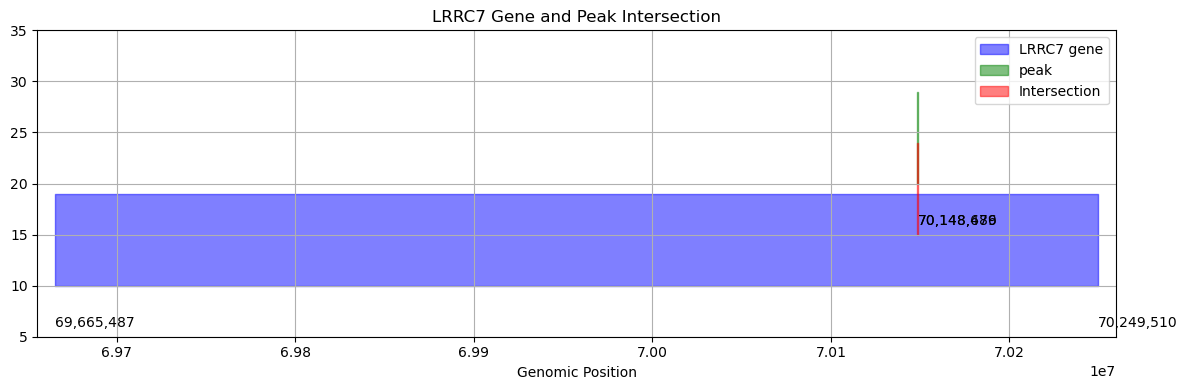

Intersection range: 70,148,486 - 70,148,679 (193 positions)


In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Define ranges
range1 = (69665487, 70249510) # LRRC7 gene coordinates
range2 = (70148486, 70148679) # peak coordinates

fig, ax = plt.subplots(figsize=(12, 4))

# Plot ranges as horizontal bars
ax.broken_barh([(range1[0], range1[1]-range1[0])], (10, 9), color='blue', alpha=0.5, label='LRRC7 gene')
ax.broken_barh([(range2[0], range2[1]-range2[0])], (20, 9), color='green', alpha=0.5, label='peak')

# Calculate and plot intersection
intersection_start = max(range1[0], range2[0])
intersection_end = min(range1[1], range2[1])
ax.broken_barh([(intersection_start, intersection_end-intersection_start)], (15, 9), 
               color='red', alpha=0.5, label='Intersection')

# Customize plot
ax.set_ylim(5, 35)
ax.set_xlim(range1[0]-10000, range1[1]+10000)
ax.set_xlabel('Genomic Position')
ax.grid(True)
ax.legend()

# Add range labels
for i, (start, end) in enumerate([(range1[0], range1[1]), (range2[0], range2[1])]):
    y = 10 if i == 0 else 20
    plt.text(start, y-3, f'{start:,}', verticalalignment='top')
    plt.text(end, y-3, f'{end:,}', verticalalignment='top')

plt.title('LRRC7 Gene and Peak Intersection')
plt.tight_layout()
plt.show()

# Calculate intersection size
intersection_size = intersection_end - intersection_start
print(f"Intersection range: {intersection_start:,} - {intersection_end:,} ({intersection_size:,} positions)")

In [104]:
import requests
import json

def get_transcript_info(gene_id):
    """
    Fetch and display information about all transcripts for a gene
    """
    base_url = "https://rest.ensembl.org"
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }
    
    ext = f"/lookup/id/{gene_id}?expand=1"
    response = requests.get(base_url + ext, headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"Failed to fetch gene data: {response.status_code}")
    
    data = response.json()
    transcripts = data.get('Transcript', [])
    
    print(f"Gene: {gene_id}")
    print(f"Number of transcripts: {len(transcripts)}")
    print("\nTranscript details:")
    
    for transcript in transcripts:
        exon_count = len(transcript.get('Exon', []))
        print(f"\nTranscript ID: {transcript['id']}")
        print(f"Exon count: {exon_count}")
        if exon_count > 0:
            first_exon = transcript['Exon'][0]
            last_exon = transcript['Exon'][-1]
            print(f"First exon coordinates: {first_exon['start']}-{first_exon['end']}")
            print(f"Last exon coordinates: {last_exon['start']}-{last_exon['end']}")

# Get information about all transcripts
get_transcript_info("ENSG00000033122")

Gene: ENSG00000033122
Number of transcripts: 14

Transcript details:

Transcript ID: ENST00000651989
Exon count: 27
First exon coordinates: 69567922-69568641
Last exon coordinates: 70121780-70144364

Transcript ID: ENST00000310961
Exon count: 27
First exon coordinates: 69568398-69568641
Last exon coordinates: 70121780-70123488

Transcript ID: ENST00000370958
Exon count: 8
First exon coordinates: 69568450-69568641
Last exon coordinates: 69873467-69875004

Transcript ID: ENST00000651217
Exon count: 25
First exon coordinates: 69760175-69760393
Last exon coordinates: 70121780-70122243

Transcript ID: ENST00000415775
Exon count: 21
First exon coordinates: 69760187-69760393
Last exon coordinates: 70121780-70121994

Transcript ID: ENST00000588515
Exon count: 6
First exon coordinates: 70107750-70107826
Last exon coordinates: 70147889-70148005

Transcript ID: ENST00000609498
Exon count: 5
First exon coordinates: 70121778-70121870
Last exon coordinates: 70142197-70142253

Transcript ID: ENST0000

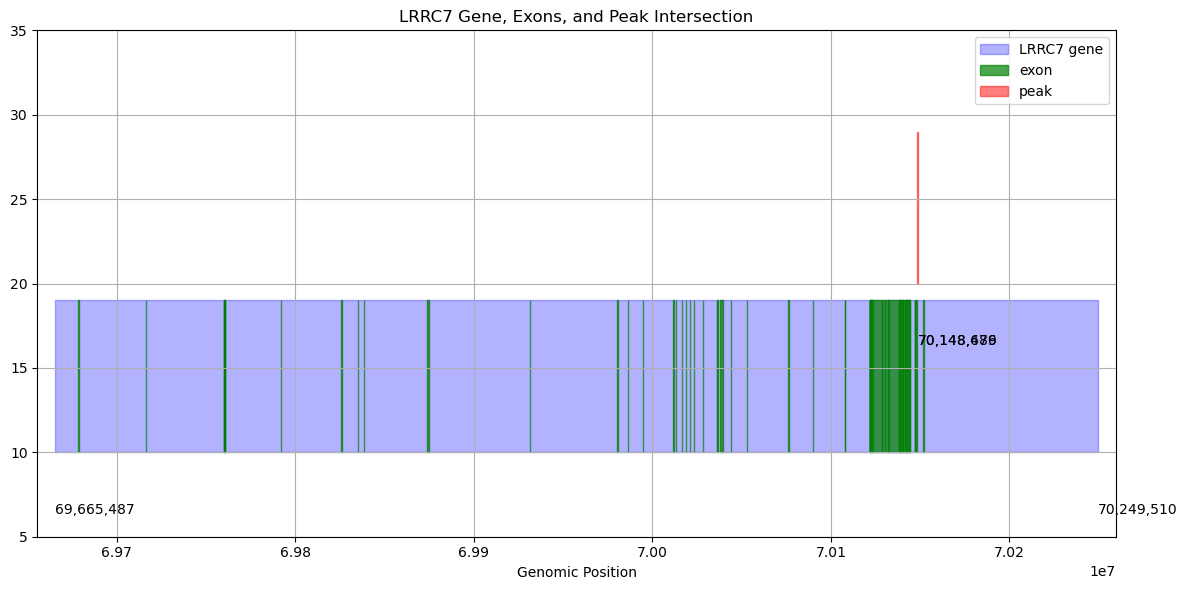

Intersection range: 70,148,486 - 70,148,679 (193 positions)
Number of exons: 57


In [105]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

def fetch_exon_coordinates(gene_id):
    """Fetch exon coordinates from Ensembl REST API"""
    base_url = "https://rest.ensembl.org"
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }
    
    ext = f"/lookup/id/{gene_id}?expand=1"
    response = requests.get(base_url + ext, headers=headers)
    
    if response.status_code != 200:
        return []
    
    data = response.json()
    exon_coords = []
    
    # Collect unique exon coordinates from all transcripts
    for transcript in data.get('Transcript', []):
        for exon in transcript.get('Exon', []):
            coords = (exon['start'], exon['end'])
            if coords not in exon_coords:
                exon_coords.append(coords)
    
    return sorted(exon_coords)

# Define ranges
range1 = (69665487, 70249510)  # LRRC7 gene coordinates
range2 = (70148486, 70148679)  # peak coordinates

# Fetch exon coordinates
exon_coords = fetch_exon_coordinates("ENSG00000033122")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot gene range
ax.broken_barh([(range1[0], range1[1]-range1[0])], (10, 9), 
               color='blue', alpha=0.3, label='LRRC7 gene')

# Plot exons
first_exon = True
for start, end in exon_coords:
    ax.broken_barh([(start, end-start)], (10, 9), 
                  color='green', alpha=0.7, 
                  label='exon' if first_exon else None)
    first_exon = False

# Plot peak
ax.broken_barh([(range2[0], range2[1]-range2[0])], (20, 9), 
               color='red', alpha=0.5, label='peak')

# Customize plot
ax.set_ylim(5, 35)
ax.set_xlim(range1[0]-10000, range1[1]+10000)
ax.set_xlabel('Genomic Position')
ax.grid(True)
ax.legend()

# Add range labels
for i, (start, end) in enumerate([(range1[0], range1[1]), (range2[0], range2[1])]):
    y = 10 if i == 0 else 20
    plt.text(start, y-3, f'{start:,}', verticalalignment='top')
    plt.text(end, y-3, f'{end:,}', verticalalignment='top')

plt.title('LRRC7 Gene, Exons, and Peak Intersection')
plt.tight_layout()
plt.show()

# Calculate intersection size
intersection_size = intersection_end - intersection_start
print(f"Intersection range: {intersection_start:,} - {intersection_end:,} ({intersection_size:,} positions)")
print(f"Number of exons: {len(exon_coords)}")

In [106]:
import gffutils

gff_file = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DATA/v38/gencode.v38.annotation.dexseq.gff"
gene_id = "ENSG00000033122.21"

In [107]:
db = gffutils.create_db(gff_file, ":memory:", merge_strategy="create_unique")

In [108]:
def examine_gff_content(gff_file, gene_id, db):
    """
    Examine the content of the GFF file for a specific gene
    """    
    # First, let's look at all features in the database
    print("\nSample of features in the database:")
    for feature in db.all_features():
        print(f"\nFeature type: {feature.featuretype}")
        print(f"ID: {feature.id}")
        print(f"Coordinates: {feature.seqid}:{feature.start}-{feature.end}")
        print("Attributes:", dict(feature.attributes))
        break  # Just show the first one as an example
    
    # Try to find our specific exon
    print("\nTrying to find specific features...")
    try:
        # Try exact ID
        feature = db[f"{gene_id}:E063"]
        print("Found by exact ID!")
    except:
        print("Not found by exact ID")
    
    # Look at all features in the relevant chromosome region
    print("\nFeatures in the relevant region:")
    for feature in db.region(seqid='chr1', start=70147000, end=70149000):
        print(f"\nFeature type: {feature.featuretype}")
        print(f"ID: {feature.id}")
        print(f"Coordinates: {feature.seqid}:{feature.start}-{feature.end}")
        print("Attributes:", dict(feature.attributes))

examine_gff_content(gff_file, gene_id, db)


Sample of features in the database:

Feature type: aggregate_gene
ID: aggregate_gene_1
Coordinates: chr1:11869-14409
Attributes: {'gene_id': ['ENSG00000223972.5']}

Trying to find specific features...
Not found by exact ID

Features in the relevant region:

Feature type: aggregate_gene
ID: aggregate_gene_1845
Coordinates: chr1:69567922-70151945
Attributes: {'gene_id': ['ENSG00000033122.21']}

Feature type: aggregate_gene
ID: aggregate_gene_1851
Coordinates: chr1:70144805-70205579
Attributes: {'gene_id': ['ENSG00000066557.6']}

Feature type: exonic_part
ID: exonic_part_24231
Coordinates: chr1:70147027-70147077
Attributes: {'gene_id': ['ENSG00000033122.21'], 'transcripts': ['ENST00000608744.5+ENST00000609072.5+ENST00000607936.5'], 'exonic_part_number': ['059']}

Feature type: exonic_part
ID: exonic_part_24232
Coordinates: chr1:70147078-70147120
Attributes: {'gene_id': ['ENSG00000033122.21'], 'transcripts': ['ENST00000608744.5+ENST00000609072.5'], 'exonic_part_number': ['060']}

Feature 

- Feature type: exonic_part
- ID: exonic_part_24235
- Coordinates: chr1:70147889-70148005
- Attributes: {'gene_id': ['ENSG00000033122.21'], 'transcripts': ['ENST00000441830.1+ENST00000607936.5+ENST00000588515.5'], 'exonic_part_number': ['063']}

In [109]:
def peek_gff_file(gff_file, num_lines=10):
    """
    Show the first few lines of the GFF file
    """
    with open(gff_file, 'r') as f:
        lines = []
        for line in f:
            if not line.startswith('#'):  # Skip comment lines
                lines.append(line.strip())
                if len(lines) >= num_lines:
                    break
    
    print("Sample lines from GFF file:")
    for line in lines:
        print(line)

# Look at the GFF file content
peek_gff_file(gff_file)

Sample lines from GFF file:
chr1	dexseq_prepare_annotation.py	aggregate_gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"
chr1	dexseq_prepare_annotation.py	exonic_part	11869	12009	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2"; exonic_part_number "001"
chr1	dexseq_prepare_annotation.py	exonic_part	12010	12057	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "002"
chr1	dexseq_prepare_annotation.py	exonic_part	12058	12178	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2"; exonic_part_number "003"
chr1	dexseq_prepare_annotation.py	exonic_part	12179	12227	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "004"
chr1	dexseq_prepare_annotation.py	exonic_part	12613	12697	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "005"
chr1	dexseq_prepare_annotation.py	exonic_part	12698	12721	.	+	.	gene

In [110]:
def get_sequence_for_coordinates(chromosome, start, end):
    """Get sequence from Ensembl REST API for given coordinates"""
    server = "https://rest.ensembl.org"
    ext = f"/sequence/region/human/{chromosome}:{start}:{end}:1"
    
    r = requests.get(server + ext, headers={"Content-Type": "application/json"})
    
    if r.status_code != 200:
        return None
        
    return r.json()['seq']

# Get sequence for E063
chromosome = "chr1"
start = 70147889
end = 70148005

sequence = get_sequence_for_coordinates(chromosome, start, end)
if sequence:
    print(f"Exon E063 sequence (length: {len(sequence)} bp):")
    print(sequence)

Exon E063 sequence (length: 117 bp):
GCACTGGGACAACTCTTTTCCAAAGAAAGACCCAAAAATCGTACAAATAAGTCCAAATGAAGCATGATGGGAAATCAGGGACTAATTCTGCTTGGAGGACAGGGAAGGCTTTCAAAG


In [111]:
def get_gene_info(chromosome, start, end):
    """Get gene information from Ensembl REST API for given coordinates"""
    server = "https://rest.ensembl.org"
    ext = f"/overlap/region/human/{chromosome}:{start}:{end}?feature=gene"
    
    r = requests.get(server + ext, headers={"Content-Type": "application/json"})
    
    if r.status_code != 200:
        return None
        
    return r.json()

# Check the peak region
peak_start = 70148486
peak_end = 70148679
genes = get_gene_info("1", peak_start, peak_end)

print("Genes in peak region:")
for gene in genes:
    print(f"Gene: {gene.get('external_name')} ({gene.get('id')})")

Genes in peak region:
Gene: LRRC40 (ENSG00000066557)
Gene: LRRC7 (ENSG00000033122)


In [119]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
import requests
import json

def search_ensembl_region(sequence, chromosome, start, end, margin=5000):
    """
    Search for sequence matches in Ensembl transcripts within specified region
    
    Args:
        sequence (str): Query sequence
        chromosome (str): Chromosome number
        start (int): Start position
        end (int): End position
        margin (int): Additional base pairs to search on each side
    """
    # Ensembl REST API endpoint
    server = "https://rest.ensembl.org"
    
    # Get transcripts in the region
    ext = f"/overlap/region/human/{chromosome}:{start-margin}-{end+margin}?"
    params = {
        "feature": "transcript",
        "content-type": "application/json"
    }
    
    try:
        r = requests.get(server + ext, params=params)
        r.raise_for_status()  # Raise exception for bad status codes
        transcripts = r.json()
        
        if not transcripts:
            print(f"No transcripts found in region chr{chromosome}:{start-margin}-{end+margin}")
            return
            
        print(f"Found {len(transcripts)} transcripts in region. Checking for sequence matches...\n")
        
        # For each transcript, get sequence and check for matches
        for transcript in transcripts:
            transcript_id = transcript.get('transcript_id', transcript.get('id', 'Unknown ID'))
            
            # Get transcript sequence
            ext = f"/sequence/id/{transcript_id}?"
            params = {
                "content-type": "application/json",
                "type": "cdna"
            }
            
            r = requests.get(server + ext, params=params)
            r.raise_for_status()
            transcript_seq = r.json().get('seq', '')
            
            # Check for sequence match
            if sequence in transcript_seq:
                print(f"Match found in transcript: {transcript_id}")
                # Using .get() method with default values to avoid KeyError
                print(f"Gene name: {transcript.get('external_name', 'Unknown')}")
                print(f"Gene ID: {transcript.get('parent', 'Unknown')}")
                print(f"Transcript biotype: {transcript.get('biotype', 'Unknown')}")
                print(f"Transcript position: chr{chromosome}:{transcript.get('start', 'Unknown')}-{transcript.get('end', 'Unknown')}")
                print("-----")
            
    except requests.exceptions.RequestException as e:
        print(f"Error accessing Ensembl API: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error parsing API response: {e}")
        return
    except Exception as e:
        print(f"Unexpected error: {e}")
        return

# Your sequence
query_seq = "GCACTGGGACAACTCTTTTCCAAAGAAAGACCCAAAAATCGTACAAATAAGTCCAAATGAAGCATGATGGGAAATCAGGGACTAATTCTGCTTGGAGGACAGGGAAGGCTTTCAAAG"

# Search parameters
chromosome = "1"
start = 70148486
end = 70148679
margin = 5000  # Search 5kb up/downstream

# Perform search
print(f"Searching for sequence in chr{chromosome}:{start-margin}-{end+margin}...")
search_ensembl_region(query_seq, chromosome, start, end, margin)

Searching for sequence in chr1:70143486-70153679...
Found 8 transcripts in region. Checking for sequence matches...

Match found in transcript: ENST00000588515
Gene name: LRRC7-206
Gene ID: Unknown
Transcript biotype: nonsense_mediated_decay
Transcript position: chr1:70107750-70148005
-----
Match found in transcript: ENST00000607936
Gene name: LRRC7-207
Gene ID: Unknown
Transcript biotype: retained_intron
Transcript position: chr1:70138284-70148005
-----
Match found in transcript: ENST00000441830
Gene name: LRRC7-204
Gene ID: Unknown
Transcript biotype: protein_coding_CDS_not_defined
Transcript position: chr1:70147121-70151945
-----


In [121]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
import requests
import json

def search_ensembl_region(sequence, chromosome, start, end, margin=5000):
    """
    Search for sequence matches in Ensembl GRCh38 transcripts within specified region
    
    Args:
        sequence (str): Query sequence
        chromosome (str): Chromosome number
        start (int): Start position
        end (int): End position
        margin (int): Additional base pairs to search on each side
    """
    # Ensembl GRCh38 REST API endpoint
    server = "https://grch37.rest.ensembl.org" if use_grch37 else "https://rest.ensembl.org"
    
    # Get transcripts in the region
    ext = f"/overlap/region/human/{chromosome}:{start-margin}-{end+margin}?"
    params = {
        "feature": "transcript",
        "content-type": "application/json",
        "assembly": "GRCh38.14"  # Explicitly specify GRCh38
    }
    
    try:
        r = requests.get(server + ext, params=params)
        r.raise_for_status()
        transcripts = r.json()
        
        if not transcripts:
            print(f"No transcripts found in region chr{chromosome}:{start-margin}-{end+margin} (GRCh38)")
            return
            
        print(f"Found {len(transcripts)} transcripts in GRCh38 region. Checking for sequence matches...\n")
        
        # For each transcript, get sequence and check for matches
        for transcript in transcripts:
            transcript_id = transcript.get('transcript_id', transcript.get('id', 'Unknown ID'))
            
            # Get transcript sequence
            ext = f"/sequence/id/{transcript_id}?"
            params = {
                "content-type": "application/json",
                "type": "cdna"
            }
            
            r = requests.get(server + ext, params=params)
            r.raise_for_status()
            transcript_seq = r.json().get('seq', '')
            
            # Check for sequence match (both forward and reverse complement)
            rev_comp = str(Seq(sequence).reverse_complement())
            if sequence in transcript_seq or rev_comp in transcript_seq:
                print(f"Match found in transcript: {transcript_id}")
                print(f"Gene name: {transcript.get('external_name', 'Unknown')}")
                print(f"Gene ID: {transcript.get('parent', 'Unknown')}")
                print(f"Transcript biotype: {transcript.get('biotype', 'Unknown')}")
                print(f"Transcript position (GRCh38): chr{chromosome}:{transcript.get('start', 'Unknown')}-{transcript.get('end', 'Unknown')}")
                print(f"Strand: {'+' if transcript.get('strand', 0) > 0 else '-'}")
                print("-----")
            
    except requests.exceptions.RequestException as e:
        print(f"Error accessing Ensembl API: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error parsing API response: {e}")
        return
    except Exception as e:
        print(f"Unexpected error: {e}")
        return

# Your sequence
query_seq = "GCACTGGGACAACTCTTTTCCAAAGAAAGACCCAAAAATCGTACAAATAAGTCCAAATGAAGCATGATGGGAAATCAGGGACTAATTCTGCTTGGAGGACAGGGAAGGCTTTCAAAG"

# Search parameters
chromosome = "1"
start = 70148486
end = 70148679
margin = 5000  # Search 5kb up/downstream

# Choose Ensembl version
use_grch37 = False  # Set to True if you want to use GRCh37/hg19 instead of GRCh38/hg38

# Perform search
print(f"Searching for sequence in chr{chromosome}:{start-margin}-{end+margin} (GRCh38)...")
search_ensembl_region(query_seq, chromosome, start, end, margin)

Searching for sequence in chr1:70143486-70153679 (GRCh38)...
Found 8 transcripts in GRCh38 region. Checking for sequence matches...

Match found in transcript: ENST00000588515
Gene name: LRRC7-206
Gene ID: Unknown
Transcript biotype: nonsense_mediated_decay
Transcript position (GRCh38): chr1:70107750-70148005
Strand: +
-----
Match found in transcript: ENST00000607936
Gene name: LRRC7-207
Gene ID: Unknown
Transcript biotype: retained_intron
Transcript position (GRCh38): chr1:70138284-70148005
Strand: +
-----
Match found in transcript: ENST00000441830
Gene name: LRRC7-204
Gene ID: Unknown
Transcript biotype: protein_coding_CDS_not_defined
Transcript position (GRCh38): chr1:70147121-70151945
Strand: +
-----


In [112]:
visualize_top_alignments(enriched_overlaps_df3)

Top 5 alignments by ALS1 score:

Gene: TASOR2 (ENSG00000108021)
Exon: E031
Peak: chr10:5746310-5746538
ALS1 Scores:
  Previous exon: 11.0
  Current exon:  8.0
  Next exon:     9.0
  Total:         28.0
ALS2 Scores:
  Previous exon: 6.0
  Current exon:  6.0
  Next exon:     8.0
  Total:         20.0
Distance to peak: 4.11 kb
Log2 fold change: -0.026
--------------------------------------------------

Gene: COMMD2 (ENSG00000114744)
Exon: E002
Peak: chr3:149739286-149739508
ALS1 Scores:
  Previous exon: 13.0
  Current exon:  6.0
  Next exon:     7.0
  Total:         26.0
ALS2 Scores:
  Previous exon: 7.0
  Current exon:  4.0
  Next exon:     5.0
  Total:         16.0
Distance to peak: -2.01 kb
Log2 fold change: 0.112
--------------------------------------------------

Gene: IRS4 (ENSG00000133124)
Exon: E003
Peak: chrX:108733099-108733294
ALS1 Scores:
  Previous exon: 9.0
  Current exon:  9.0
  Next exon:     8.0
  Total:         26.0
ALS2 Scores:
  Previous exon: 7.0
  Current exon:  8.0
